In [181]:
## COMP9517 Computer Vision Project 20T2
# code: Main program for the project
#
# Group C:
# Connor Baginski (z5207788)
# Bhumika Singhal (z5234799)
# Rishav Guha (z5294757)
# Amel Johny (z5294308)

#import for cell tracking with centroid tracking algorithm
# from cell_tracking.centroidtracker import CentroidTracker
# from cell_tracking.detectors import Detectors
# from cell_tracking.tracker import Tracker
from cell_tracking.kalmanFilter import KalmanFilter
# from cell_tracking.common import dprint
from scipy.optimize import linear_sum_assignment


import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max
from skimage.filters import meijering

from scipy import ndimage as ndi


def fi_list(path):
    """
    Return a sorted list of filenames in a given path
    """
    return sorted([os.path.join(path, f) for f in os.listdir(path)])

def custom_thresh(image):
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            if image[r,c] > 0.05:
                image[r,c] = 255
            else:
                image[r,c] = 0

    return image

def disk_erode(img, radius=24, iters=1):
    image = img.copy()
    kern_disk = disk(radius)
    eroded = cv2.erode(image, kern_disk, iterations=iters)
    
    return eroded


In [182]:
def detect_DIC():
    for filename in fi_list('DIC-C2DH-HeLa/Sequence 1 Masks'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        plt.title("Ground Truth")
        plt.imshow(image)
        plt.show()
        
        cell_mask = (image > 0).astype(np.uint8)
        plt.imshow(cell_mask)
        plt.show()
        
        markers = disk_erode(cell_mask)
        plt.title("Markers")
        plt.imshow(markers)
        plt.show()
        """
        blurred = cv2.medianBlur(image, 21)
        
        denoised = cv2.fastNlMeansDenoising(blurred, h=3)        
        
        # adaptive normalization - see paper https://is.muni.cz/www/svoboda/ISBI-final.pdf
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl1 = clahe.apply(denoised)
        
        mj_filtered = meijering(cl1)
        mj_filtered = custom_thresh(mj_filtered)
        
        kernel = np.ones((4,4),np.uint8)

        eroded = cv2.erode(mj_filtered, kernel, iterations=1)

        thresh = cv2.threshold(eroded, 129, 255, cv2.THRESH_BINARY)[1]

        distance = ndi.distance_transform_edt(thresh)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
                                labels=thresh)
        markers, _ = ndi.label(local_maxi)
        ws_labels = watershed(-distance, markers, mask=thresh)
        
        plt.gray()
        plt.imshow(image)
        plt.show()
        
        plt.imshow(blurred)
        plt.show()
        
        plt.imshow(denoised)
        plt.show()
        
        plt.imshow(cl1)
        plt.show()
        
        plt.imshow(mj_filtered)
        plt.show()
        
        plt.imshow(eroded)
        plt.show()
        
        plt.imshow(thresh, cmap='gray')
        plt.show()
        
        plt.imshow(ws_labels)
        plt.show()
        
        #break stops loop after one iteration for debugging
        break
        """
    return

In [183]:
 #TODO: cite/recode following
class Track(object):
    """Track class for every object to be tracked
    Attributes:
        None
    """

    def __init__(self, prediction, trackIdCount):
        """Initialize variables used by Track class
        Args:
            prediction: predicted centroids of object to be tracked
            trackIdCount: identification of each track object
        Return:
            None
        """
        self.track_id = trackIdCount  # identification of each track object
        self.KF = KalmanFilter(0.1, 1, 1, 1, 0.1,0.1)  # KF instance to track this object
        self.prediction = np.asarray(prediction)  # predicted centroids (x,y)
        self.skipped_frames = 0  # number of frames skipped undetected
        self.trace = []  # trace path

class Tracker(object):
    """Tracker class that updates track vectors of object tracked
    Attributes:
        None
    """

    def __init__(self, dist_thresh, max_frames_to_skip, max_trace_length,
                 trackIdCount):
        """Initialize variable used by Tracker class
        Args:
            dist_thresh: distance threshold. When exceeds the threshold,
                         track will be deleted and new track is created
            max_frames_to_skip: maximum allowed frames to be skipped for
                                the track object undetected
            max_trace_lenght: trace path history length
            trackIdCount: identification of each track object
        Return:
            None
        """
        self.dist_thresh = dist_thresh
        self.max_frames_to_skip = max_frames_to_skip
        self.max_trace_length = max_trace_length
        self.tracks = []
        self.trackIdCount = trackIdCount

    def Update(self, detections):
        """Update tracks vector using following steps:
            - Create tracks if no tracks vector found
            - Calculate cost using sum of square distance
              between predicted vs detected centroids
            - Using Hungarian Algorithm assign the correct
              detected measurements to predicted tracks
              https://en.wikipedia.org/wiki/Hungarian_algorithm
            - Identify tracks with no assignment, if any
            - If tracks are not detected for long time, remove them
            - Now look for un_assigned detects
            - Start new tracks
            - Update KalmanFilter state, lastResults and tracks trace
        Args:
            detections: detected centroids of object to be tracked
        Return:
            None
        """

        # Create tracks if no tracks vector found
        if (len(self.tracks) == 0):
            for i in range(len(detections)):
                track = Track(detections[i], self.trackIdCount)
                self.trackIdCount += 1
                self.tracks.append(track)

        # Calculate cost using sum of square distance between
        # predicted vs detected centroids
        N = len(self.tracks)
        M = len(detections)
        cost = np.zeros(shape=(N, M))   # Cost matrix
        for i in range(len(self.tracks)):
            for j in range(len(detections)):
                try:
                    diff = self.tracks[i].prediction - detections[j]
                    distance = np.sqrt(diff[0][0]*diff[0][0] +
                                       diff[1][0]*diff[1][0])
                    cost[i][j] = distance
                except:
                    pass

        # Let's average the squared ERROR
        cost = (0.5) * cost
        # Using Hungarian Algorithm assign the correct detected measurements
        # to predicted tracks
        assignment = []
        for _ in range(N):
            assignment.append(-1)
        row_ind, col_ind = linear_sum_assignment(cost)
        for i in range(len(row_ind)):
            assignment[row_ind[i]] = col_ind[i]

        # Identify tracks with no assignment, if any
        un_assigned_tracks = []
        for i in range(len(assignment)):
            if (assignment[i] != -1):
                # check for cost distance threshold.
                # If cost is very high then un_assign (delete) the track
                if (cost[i][assignment[i]] > self.dist_thresh):
                    assignment[i] = -1
                    un_assigned_tracks.append(i)
                pass
            else:
                self.tracks[i].skipped_frames += 1

        # If tracks are not detected for long time, remove them
        del_tracks = []
        for i in range(len(self.tracks)):
            if (self.tracks[i].skipped_frames > self.max_frames_to_skip):
                del_tracks.append(i)
        if len(del_tracks) > 0:  # only when skipped frame exceeds max
            for id in del_tracks:
                if id < len(self.tracks):
                    del self.tracks[id]
                    del assignment[id]
                else:
                    dprint("ERROR: id is greater than length of tracks")

        # Now look for un_assigned detects
        un_assigned_detects = []
        for i in range(len(detections)):
                if i not in assignment:
                    un_assigned_detects.append(i)

        # Start new tracks
        if(len(un_assigned_detects) != 0):
            for i in range(len(un_assigned_detects)):
                track = Track(detections[un_assigned_detects[i]],
                              self.trackIdCount)
                self.trackIdCount += 1
                self.tracks.append(track)

        # Update KalmanFilter state, lastResults and tracks trace
        for i in range(len(assignment)):
            self.tracks[i].KF.predict()

            if(assignment[i] != -1):
                self.tracks[i].skipped_frames = 0
                self.tracks[i].prediction = self.tracks[i].KF.correct(
                                            detections[assignment[i]], 1)
            else:
                self.tracks[i].prediction = self.tracks[i].KF.correct(
                                            np.array([[0], [0]]), 0)

            if(len(self.tracks[i].trace) > self.max_trace_length):
                for j in range(len(self.tracks[i].trace) -
                               self.max_trace_length):
                    del self.tracks[i].trace[j]

            self.tracks[i].trace.append(self.tracks[i].prediction)
            self.tracks[i].KF.lastResult = self.tracks[i].prediction


In [184]:

def track_path(image,centers, trackIdCount, tracker):
    dist_thresh = 20
    max_frames_to_skip = 3
    max_trace_length = 700
    if (len(centers) > 0):
                
            # tracker.Track object using Kalman Filter
            # tracker.tracker.Update(centers)
            print('length of tracker.tracks', len(tracker.tracks))
            if (len(tracker.tracks) == 0):
                for i in range(len(centers)):
                    
                    tracker.track = Track(np.array(centers[i]), tracker.trackIdCount)
                    tracker.trackIdCount += 1
                    tracker.tracks.append(tracker.track)
            # Calculate cost using sum of square distance between
            # predicted vs detected centroids
            N = len(tracker.tracks)
            M = len(centers)
            cost = np.zeros(shape=(N, M))   # Cost matrix
            for i in range(len(tracker.tracks)):
                for j in range(len(centers)):
                    try:
                        diff = tracker.tracks[i].prediction - centers[j]
                        distance = np.sqrt(diff[0][0]*diff[0][0] +
                                        diff[1][0]*diff[1][0])
                        cost[i][j] = distance
                    except:
                        pass
            # print(tracker.track.prediction)
            # Let's average the squared ERROR
            
            cost = (0.5) * cost
            # Using Hungarian Algorithm assign the correct detected measurements
            # to predicted tracker.tracks
            assignment = []
            for _ in range(N):
                assignment.append(-1)
            row_ind, col_ind = linear_sum_assignment(cost)
            for i in range(len(row_ind)):
                assignment[row_ind[i]] = col_ind[i]
            # Identify tracker.tracks with no assignment, if any
            un_assigned_tracks = []
            for i in range(len(assignment)):
                if (assignment[i] != -1):
                    # check for cost distance threshold.
                    # If cost is very high then un_assign (delete) the tracker.track
                    if (cost[i][assignment[i]] > dist_thresh):
                        assignment[i] = -1
                        un_assigned_tracks.append(i)
                    pass
                else:
                    tracker.tracks[i].skipped_frames += 1

            # If tracker.tracks are not detected for long time, remove them
            del_tracks = []
            for i in range(len(tracker.tracks)):
                if (tracker.tracks[i].skipped_frames > max_frames_to_skip):
                    del_tracks.append(i)
            if len(del_tracks) > 0:  # only when skipped frame exceeds max
                for id in del_tracks:
                    if id < len(tracker.tracks):
                        del tracker.tracks[id]
                        del assignment[id]
                    else:
                        print("ERROR: id is greater than length of tracker.tracks")

            # Now look for un_assigned detects
            un_assigned_detects = []
            for i in range(len(centers)):
                    if i not in assignment:
                        un_assigned_detects.append(i)

            # Start new tracker.tracks
            if(len(un_assigned_detects) != 0):
                for i in range(len(un_assigned_detects)):
                    tracker.track = Track(centers[un_assigned_detects[i]],
                                tracker.trackIdCount)
                    tracker.trackIdCount += 1
                    tracker.tracks.append(tracker.track)
            
            # Update KalmanFilter state, lastResults and tracker.tracks trace
            for i in range(len(assignment)):
                (x, y) =tracker.tracks[i].KF.predict()
                
                if(assignment[i] != -1):
                    tracker.tracks[i].skipped_frames = 0
                    tracker.tracks[i].prediction = tracker.tracks[i].KF.update(centers[assignment[i]])
                    tracker.tracks[i].trace.append(tracker.tracks[i].prediction)
                # else:
                    # try:
                        # last = tracker.tracks[i].trace.pop()
                        # print('\ntrace:',tracker.tracks[i].trace)
                        # print('\n - last:',last,'\n\n\n')
                        # last_center = np.eye(last)
                        # print('last -->',np.eye(last))
                        # print('last[0] -->',last[0])
                        # print('\nlast[1] -->',last[1])
                        # tracker.tracks[i].prediction = tracker.tracks[i].trace.append(last_center)
                        # tracker.tracks[i].prediction = tracker.tracks[i].trace.append(last_center)
                    # except:
                        # print('\ntrace:',tracker.tracks[i].trace)
                        # print('\n - last:',last,'\n\n\n')
                        # sys.exit()
                if(len(tracker.tracks[i].trace) > max_trace_length):
                    for j in range(len(tracker.tracks[i].trace) -
                                max_trace_length):
                        del tracker.tracks[i].trace[j]

                
                # tracker.tracks[i].KF.lastResult = tracker.tracks[i].prediction
    # print(centers) ##FOR DEBUGGING    
    for i in range(len(tracker.tracks)):
                if (len(tracker.tracks[i].trace) > 0):
                    for j in range(len(tracker.tracks[i].trace)-1):
                        ##FOR DEBUGGING
                        # print('tracker.track_id', tracker.tracks[i].tracker.track_id)
                        # print('tracker.track_j[0][0]', tracker.tracks[i].trace[j][0][0])
                        # print('tracker.track_j[1][1]', tracker.tracks[i].trace[j][1][0])
                        # print('tracker.track_j+1[0][0]', tracker.tracks[i].trace[j+1][0][0])
                        # print('tracker.track_j+1[1][1]', tracker.tracks[i].trace[j+1][1][0])
                        # Draw trace line
                        try:
                            x1 = tracker.tracks[i].trace[j][0][0]
                            y1 = tracker.tracks[i].trace[j][1][0]
                            x2 = tracker.tracks[i].trace[j+1][0][0]
                            y2 = tracker.tracks[i].trace[j+1][1][0]
                            clr = tracker.tracks[i].track_id % 9
                            cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)),
                                    (0,255,0), 2)
                        except:
                            print(tracker.tracks[i].trace)
                        # print(x1,y1,x2,y2,clr)
                        # print(tracker.tracks[i].KF)
                        # print(tracker.tracks[i].prediction)
                        # print(tracker.tracks[i].skipped_frames)
                        # print(tracker.tracks[i].trace)
                       
                        # cv2.putText(image, "#{}".format(tracker.tracks[i].tracker.track_id), (int(x1) - 10, int(y1)),
                        #     cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    return image

In [185]:
def detect_Fluo():
    #initialising variables for tracking
    tracks = []
    trackIdCount = 0
    for filename in fi_list('Fluo-N2DL-HeLa/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        # print(filename)
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        # Threshold at value of 129
        thresh = cv2.threshold(image, 129, 255, cv2.THRESH_BINARY)[1]
        distance = ndi.distance_transform_edt(thresh)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
                                labels=thresh)
        markers, _ = ndi.label(local_maxi)
        ws_labels = watershed(-distance, markers, mask=thresh)
        
        #TODO: cite/recode following
        # loop over the unique labels returned by the Watershed
        # algorithm
        centers = []
        for label in np.unique(ws_labels):
            # if the label is zero, we are examining the 'background'
            # so simply ignore it
            if label == 0:
                continue

            # otherwise, allocate memory for the label region and draw
            # it on the mask
            mask = np.zeros(image.shape, dtype="uint8")
            mask[ws_labels == label] = 255

            # detect contours in the mask and grab the largest one
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            c = max(cnts, key=cv2.contourArea)

            # draw a rectangle enclosing the object
            try:
                x,y,w,h = cv2.boundingRect(c)
                center = np.array([[int(x + w / 2.0)], [int(y + h / 2.0)]])
                centers.append(np.round(center))
                # print(bounding_box_center)
                
            except ZeroDivisionError:
                pass
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        image = track_path(image,centers,tracks,trackIdCount)
        plt.gray()
        plt.imshow(thresh, cmap='gray')
        plt.show()
        plt.imshow(image)
        plt.show()
    return



In [186]:

def detect_PhC():
    # corner_track_params = dict(maxCorners = 10000,
    #                    qualityLevel = 0.3,
    #                    minDistance = 7,
    #                    blockSize = 7 )
    # # Parameters for lucas kanade optical flow
    # lk_params = dict( winSize  = (200,200),
    #               maxLevel = 2,
    #               criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10,0.03))
    # Create Object Detector
     # vector of object centroids in a frame
    
    # Create Object Tracker
    #initialising variables for tracking
    
    # Create Object Tracker
    tracker = Tracker(160, 30, 5, 100)
    # tracks = []
    skip_frame_count = 0
    track_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
                    (0, 255, 255), (255, 0, 255), (255, 127, 255),
                    (127, 0, 255), (127, 0, 127)]
    pause = False
    trackIdCount = 0
    for filename in fi_list('PhC-C2DL-PSC/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        thresh = cv2.threshold(image, 162, 255, cv2.THRESH_BINARY)[1]
        kernel = np.ones((4,4),np.uint8)
        # Perform an erosion followed by dilation opening to remove noise
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        distance = ndi.distance_transform_edt(opening)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
                                labels=thresh)
        markers, _ = ndi.label(local_maxi)
        ws_labels = watershed(-distance, markers, mask=thresh)
        
        #TODO: cite/recode following
        # loop over the unique labels returned by the Watershed
        # algorithm
        
        centers = []
        for label in np.unique(ws_labels):
            # if the label is zero, we are examining the 'background'
            # so simply ignore it
            if label == 0:
                continue
        
            # otherwise, allocate memory for the label region and draw
            # it on the mask
            mask = np.zeros(image.shape, dtype="uint8")
            mask[ws_labels == label] = 255

            # detect contours in the mask and grab the largest one
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            c = max(cnts, key=cv2.contourArea)
            # draw a rectangle enclosing the object
            try:
                x,y,w,h = cv2.boundingRect(c)
                center = np.array([[int(x + w / 2.0)], [int(y + h / 2.0)]])
                centers.append(np.round(center))
                # print(bounding_box_center)
                
            except ZeroDivisionError:
                pass
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        #TODO: cite/recode following 
        # print('centres', centers)
        print(len(centers))
        # print(centers)
        image = track_path(image,centers,trackIdCount,tracker)
        plt.imshow(image, cmap="gray")
        plt.show()
#         plt.imshow(opening, cmap='gray')
#         plt.show()
        # plt.imshow(ws_labels, cmap='gray')
        # plt.show()
    return

122
length of tracker.tracks 0


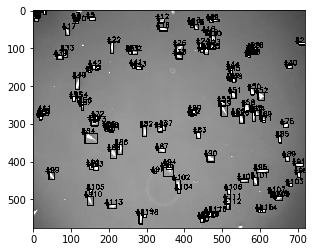

122
length of tracker.tracks 122


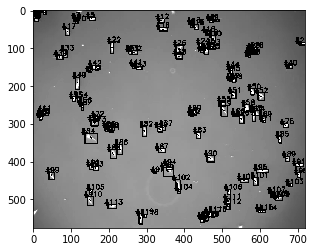

119
length of tracker.tracks 122


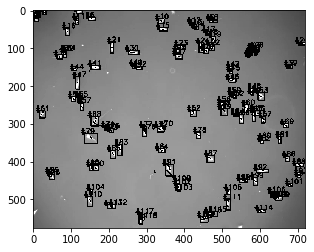

115
length of tracker.tracks 140


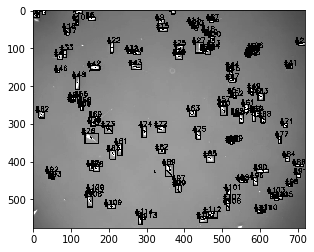

118
length of tracker.tracks 149


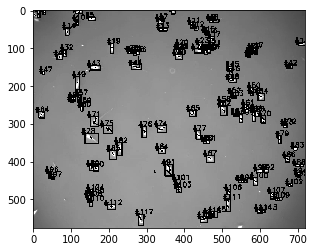

112
length of tracker.tracks 161


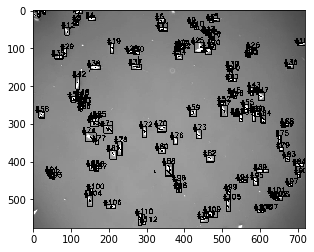

112
length of tracker.tracks 168


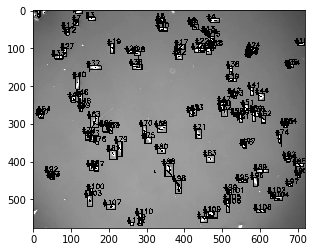

126
length of tracker.tracks 164


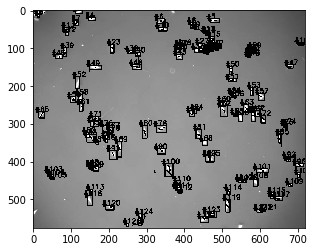

106
length of tracker.tracks 171


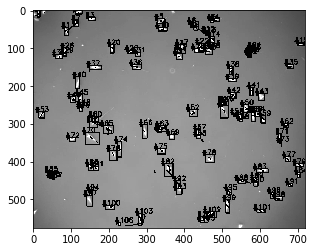

104
length of tracker.tracks 165


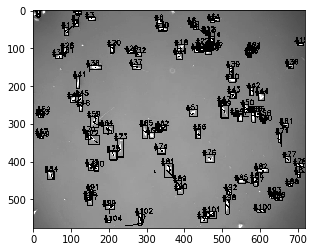

116
length of tracker.tracks 157


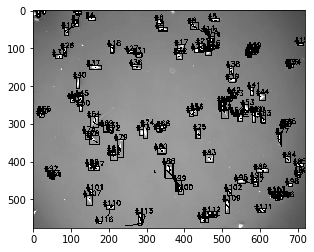

In [187]:
def main():
    select = int(input("Choose a dataset.\n1) DIC-C2DH-HeLa\n2) Fluo-N2DL-HeLa\n3) PhC-C2DL-PSC\n> "))
    # select = 3 ##FOR TESTING

    if select == 1:
        detect_DIC()
    elif select == 2:
        detect_Fluo()
    elif select == 3:
        detect_PhC()
    else:
        print("Invalid input.")

if __name__ == '__main__':
    main()

[[[233]], [[344]]]


In [188]:
# np.flat(last_center)